# RFM

### recency_data = 현재 날짜 - 고객 ID별 가장 마지막 구매일
- 현재날짜를 maxdate로()('2021-12-31')로 가정

In [ ]:
sports_rfm = sports[(sports['clac'] == '스포츠')]

In [ ]:
recency_data = sports_rfm.groupby('cust',as_index= False )['de_dt'].max()  #as_index: reset_index 랑 동일
recency_data.columns = ['CustomerID', 'LastPurchaseDate']

*** 현재날짜변경***

In [ ]:
# 현재날짜를 maxdate로()('2021-12-31')로 가정
recency_data['Recency'] = recency_data['LastPurchaseDate'].apply(lambda x: (sports_rfm['de_dt'].max() - x).days)


In [ ]:
recency_data.drop(columns =['LastPurchaseDate'],inplace = True )

### Frequency(최빈성)

- invoiceNo(rct_no와 동일): 다양한 물품을 구매해도, 송장번호가 한개면 한번 구매한것으로 여김

In [ ]:
frequency_data = sports_rfm.copy()

# 어떤 물품을 구매했는지가 아니라, 한 사람한테 몇개의 영수증번호가 있는지 매칭 
frequency_data.drop_duplicates(subset = ['cust','rct_no'], keep = 'first',inplace = True)

frequency_data = frequency_data.groupby('cust', as_index = False)['rct_no'].count()
frequency_data.columns = ['CustomerID','Frequency']

### Monetary (금액)

In [ ]:
monetary_data=c_ana.groupby('cust',as_index=False)['buy_am'].sum()
monetary_data.columns = ['CustomerID','Monetary']

merge 해주기 (recency + frequency + monetary)

In [ ]:
rf = recency_data.merge(frequency_data, how = 'left', on='CustomerID')
rfm = rf.merge(monetary_data, how = 'left', on='CustomerID')

### 스케일링 (minmax)
- minmax_scale: 최대값을 1. 최소값을 0으로 표준화 하는 기법
- RFM을 하나의 점수로 환산시켜야 함
- 현재 각각의 단위가 다르기 때문에 각 컬럼별 기준으로 표준화 필요

In [ ]:
from sklearn.preprocessing import minmax_scale

## 최근성: 숫자가 작을수록 좋음
# 즉, 최근 구매일이 얼마 지나지 않은 고객이 더 점수가 높음

rfm['Recency'] = minmax_scale(rfm['Recency'], axis = 0, copy = True )
#행기준으로, 카피해서 만들기
rfm['Recency'] = 1 - rfm['Recency']  # 작은값이 좋기 때문에, 1에서 빼줌(반전)

rfm['Frequency'] = minmax_scale(rfm['Frequency'], axis = 0, copy = True )

rfm['Monetary'] = minmax_scale(rfm['Monetary'], axis = 0, copy = True )


In [ ]:
# score
rfm['Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']

# score 에 minmax_scale 적용
# 100을 곱해서 100점 만점으로 스케일링

rfm['Score'] = minmax_scale(rfm['Score'], axis = 0, copy = True) * 100

rfm['Score'] = round(rfm['Score'], 0)

In [ ]:
sports = sports.merge(rfm, left_on = 'cust', right_on = 'CustomerID', how='left')

In [ ]:
sports = sports.fillna('0')

In [ ]:
# null값 없음
sports.isnull().sum().sum()

0

In [ ]:
# 필요없는 열 삭제

sports.drop(['clac','live_zon','rct_no','de_dt','CustomerID'], axis=1, inplace=True)

In [ ]:
sports.drop(['Recency','Frequency','Monetary'], axis=1, inplace=True)

In [ ]:
sports['Score'] = sports['Score'].astype('float') # Score str -> float

# 모델링

## train_valid, test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score, confusion_matrix, recall_score, precision_score


# 스포츠를 산다 1, 안산다 0 (y값)
X = sports.drop(['sports'], axis=1)
y = sports['sports']

# train, test 나누기
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)


# 1. test 데이터에서 cust_ID 나누기
test_id = X_test['cust'] 

# 2. X_test에서  cust_ID 삭제
X_test.drop(['cust'], axis=1, inplace=True)

# 3. X_train_valid 데이터에서 ID 삭제
X_train_valid.drop(['cust'], axis=1, inplace=True)

## Feature Engineer

In [ ]:
# OneHot Encoding 

X_train_valid = pd.get_dummies(X_train_valid)

# 모델링 이후 test 할 때를 위해 get_dummies
X_test_copy = pd.get_dummies(X_test)

## train, valid set 나누기

In [ ]:
# X_train_test 에서 train 과 test 나누기
# X_train, y_train
# X_valid, y_valid
X_train , X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.25, random_state = 1234, stratify=y_train_valid)

##  SMOTE 오버 샘플링



In [ ]:
# y값의 분포가 매우 불균형하여 smote기법으로 오버 샘플링 이후 모델에 적용

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트:  (2135712, 45) (2135712,)
SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트:  (4177498, 45) (4177498,)
SMOTE 적용 후 레이블 값 분포: 
 0    2088749
1    2088749
Name: sports, dtype: int64


## 모델 예측 성능

In [ ]:
# lightgbm
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)

In [ ]:
lgbm_clf.fit(X_train_over, y_train_over)

In [ ]:
pred = lgbm_clf.predict(X_valid)
pred_proba = lgbm_clf.predict_proba(X_valid)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score

accuracy = accuracy_score(y_valid, pred)
roc_auc = roc_auc_score(y_valid, pred_proba)

print(f'정확도:{accuracy}, AUC:{roc_auc}')

정확도:0.961271517969392, AUC:0.9629518213276089


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

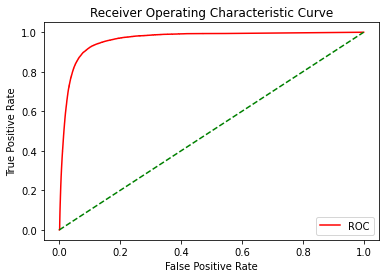

In [ ]:
from sklearn.metrics import roc_curve
pred_proba = lgbm_clf.predict_proba(X_valid)[:,1]
fper, tper, thresholds = roc_curve(y_valid, pred_proba)
plot_roc_curve(fper, tper)

In [ ]:
test_pred = lgbm_clf.predict(X_test_copy)

In [ ]:
result = pd.DataFrame({'cust_id' : test_id, 'purchase' : test_pred})

In [ ]:
X_test = X_test[['month','day','weekday']]